Desarrollar un Modelo de Riesgo de crédito

In [1]:
#Se realizara  un modelo de riesgo crediticio basado en datos en Python para predecir las probabilidades
#de incumplimiento (PD) y asignar puntajes crediticios a los prestatarios existentes o potenciales. Se determinarán los puntajes de crédito 
#utilizando un cuadro de mando altamente interpretable, fácil de entender e implementar que hace que calcular el puntaje de crédito sea 
#muy sencillo.

In [2]:
#Los datos sin procesar incluyen información sobre más de 450 000 préstamos de consumo emitidos entre 2007 y 2014 con casi 75 características, 
#incluido el estado actual del préstamo y varios atributos relacionados con los prestatarios y su comportamiento de pago.

In [3]:
#Según la exploración de datos, nuestra variable objetivo parece ser loan_status.
#Se escoge el siguiente dataset: https://drive.google.com/file/d/1xaF743cmUgI5kc76I86AeZDE84SMkMnt/view

In [4]:
#Conformación del grupo:
#Carlos Leonardo Sarmiento Alcala
#Nicolas Sotelo

In [5]:
#Importación de librerías
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
from seaborn import distplot
from seaborn import distplot
from seaborn import boxplot
from seaborn import violinplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import seaborn as sns
tabla = pd.read_csv("loan_data.csv", sep=',')


In [6]:
columnas = tabla.columns
print(columnas)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [7]:
#Se borran las columnas redundantes
tabla.drop(columns = ['id','member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title','zip_code','recoveries', 'collection_recovery_fee','total_rec_prncp', 'total_rec_late_fee','application_type'], inplace = True)


In [8]:
#Se borran las columnas que tienen mas del 80% de los datos nulos
tabla.dropna(thresh = tabla.shape[0]*0.2, how = 'all', axis = 1, inplace = True)
df_tabla_nulos = tabla.isnull().sum()

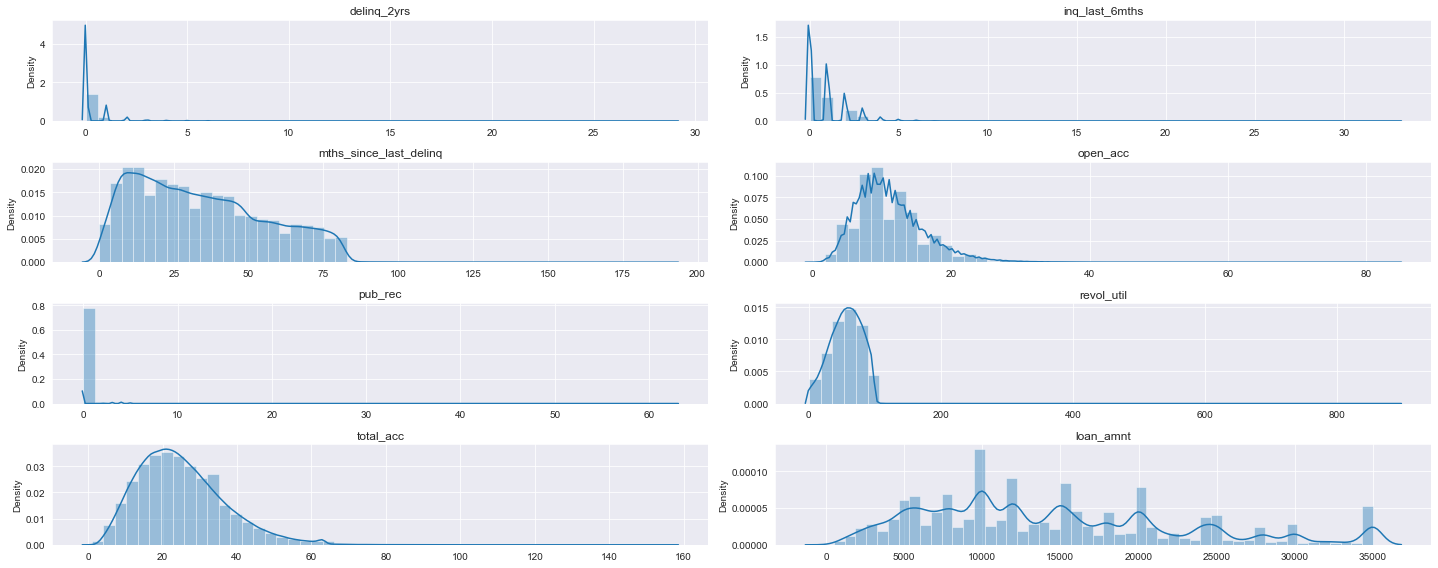

In [9]:
# De las variabes que   todavia tienen nan Se realiza la comparación de varias variables de interés en un gráfico simultaneo,  a find e de dterminar cual es su valor promedio
variables = ['delinq_2yrs','inq_last_6mths','mths_since_last_delinq','open_acc','pub_rec','revol_util','total_acc','loan_amnt']
columns = 2
fig, axes = plt.subplots(4,2)
for current_idx, variable in enumerate(variables):
    i = current_idx // columns
    j = current_idx % columns
    sns.distplot(tabla[variable], ax=axes[i][j])
    axes[i][j].set_title(variable)
    axes[i][j].set_xlabel("")
plt.gcf().set_size_inches(20, 8)
plt.tight_layout()


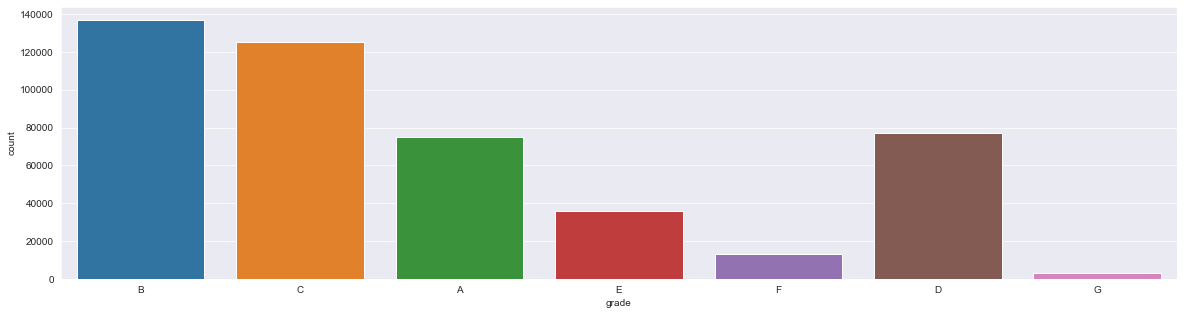

In [10]:
#Se añade conteo de las veces en las que se clasifica en cierto grado de crédito
plt.figure(figsize = (20,5))
sns.countplot(x = tabla['grade'], data = tabla)
plt.show()

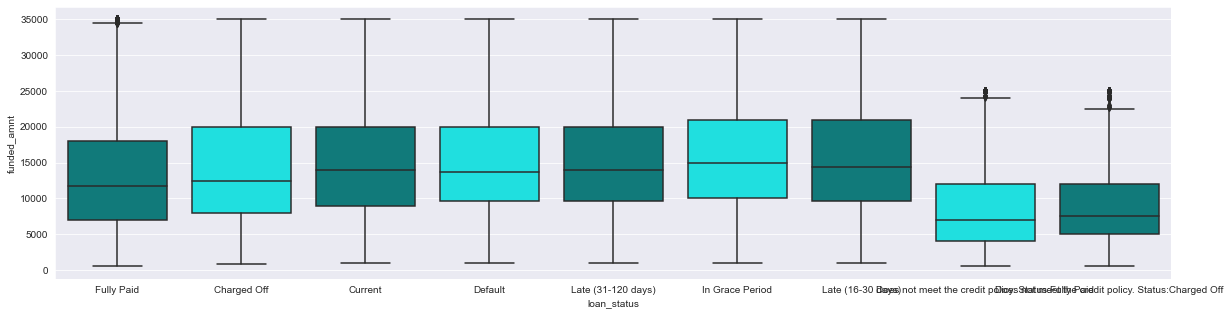

In [11]:
#Visualización de estado de préstamo contra cantidad aprobada para préstamo
plt.figure(figsize = (20,5))
sns.boxplot(x='loan_status', y = 'funded_amnt',data = tabla, palette = ['#008B8B','#00FFFF'])
plt.show()

In [12]:
#convertimos  el dato de fecha a formato data time de las variables 'earliest_cr_line','issue_d', 'last_pymnt_d' y 'last_credit_pull_d'

def date_columns(tabla, column):
    tabla[column] = pd.to_datetime(tabla[column], format = "%b-%y")
   #create a new column as a difference between today and the respective date
    today_date = pd.to_datetime('2022-03-29')
    # calculate the difference in months and add to a new column
    tabla['mths_since_' + column] = round(pd.to_numeric((today_date - tabla[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    tabla['mths_since_' + column] = tabla['mths_since_' + column].apply(lambda x: tabla['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    tabla.drop(columns = [column], inplace = True)
date_columns(tabla, 'earliest_cr_line')
date_columns(tabla, 'issue_d')
date_columns(tabla, 'last_pymnt_d')
date_columns(tabla, 'last_credit_pull_d')

In [13]:
#Se reemplazan los valores nulos por 0
tabla.fillna(value = 0, inplace = True)
#Se transforma la variable term a nuérica
tabla['term'] = pd.to_numeric(tabla['term'].str.replace(' months', ''))

In [14]:
#Renombrar las columnas
tabla_df=tabla.rename(columns={'loan_amnt':'Monto_prestado', 'funded_amnt':'Deuda_neta', 'funded_amnt_inv':'Deuda_total', 'term':'Nª_de_pagos', 'int_rate':'Tasa_de_interes',
       'installment':'Pago_mensual', 'grade':'Grado_del_prestamo','emp_length':'Antigüedad_en_el_empleo', 'home_ownership':'Vivienda', 'annual_inc':'Ingresos_Anuales',
       'verification_status':'Verificacion_de_garantias', 'pymnt_plan':'Plan_de_pago', 'purpose':'Categoria_del_deudor_requerida', 'addr_state':'Provincia', 'dti':'ratio_de_solvencia',
       'delinq_2yrs':'Morosidad(q)_en__2_años', 'inq_last_6mths':'Consultas_(q)_6_mths', 'mths_since_last_delinq':'Meses_de_morosidad', 'open_acc':'Cantidad_de_creditos',
       'pub_rec':'Q_de_registros_negativos', 'revol_bal':'Rotacion_de_credito', 'revol_util':'Ratio_de_disponibilidad', 'total_acc':'Total_de_creditos_por_persona',
       'initial_list_status':'Cotizacion_del_prestamo', 'out_prncp':'Monto_total_adeudado', 'out_prncp_inv':'Capital_adeudado', 'total_pymnt':'Total_de_pagos',
       'total_pymnt_inv':'Total_de_pagos_recibido', 'total_rec_int':'Total_de_intereses_pagados', 'last_pymnt_amnt':'Pago_total_(recibido)', 'next_pymnt_d':'Proximo_pago',
       'collections_12_mths_ex_med':'Cobros_(q)en_los_ultimos_12_meses', 'mths_since_last_major_derog':'(Q)Meses_(desde_la_ultima_calificacion)', 
       'policy_code':'Codigo_prestamo', 'acc_now_delinq':'Q_de_creditos_en_mora', 'tot_coll_amt':'Total_de_creditos_en_mora', 'tot_cur_bal':'Total_de_deudas',
       'total_rev_hi_lim':'Limite_de_credito', 'mths_since_earliest_cr_line':'meses_desde_la_apertura_del_1_credito', 'mths_since_issue_d':'q_de_mths_desde la financiacion',
       'mths_since_last_pymnt_d':'q_de_mths_desde_el_ultimo_pago','mths_since_last_credit_pull_d':'q_de_mths_desde_el_ultimo_credito'   },inplace=True)

#variable target= el objetivo es la variable loan status
target_analysis = tabla['loan_status'].value_counts(normalize = True)

#creamos la variable objetivo 0 las malas y 1 las buenas; las malas serian las categorias charged Off, Default, Late (31–120 days), Does not meet the credit policy. Status:Charged Off, el resto se consideran buenas
tabla['bueno_malo'] = np.where(tabla.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)

In [15]:
#Se divide el dataset en conjuntos de pruebas y entrenamiento para futuros análisis como el de Arbol de decision
X = tabla.drop('bueno_malo', axis = 1)
y = tabla['bueno_malo']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)
X_train, X_test = X_train.copy(), X_test.copy()

In [16]:
#Se divide en dos dataframes para separar los datos numéricos de los categóricos
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()
X_test_cat = X_test.select_dtypes(include = 'object').copy()
X_test_num = X_test.select_dtypes(include = 'number').copy()

In [19]:
#Se construye el arbol de decision y se imprimen predicciones
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=44,max_depth=2)
tree.fit(X_test_num, y_test)


DecisionTreeClassifier(max_depth=2, random_state=44)

In [20]:
#Se realiza la predicción
y_test_pred = tree.predict(X_test_num) #Prediccion en Test
from sklearn.metrics import accuracy_score
test_accuracy=accuracy_score(y_test,y_test_pred)
print(test_accuracy)

0.898810459945956


[0 1]


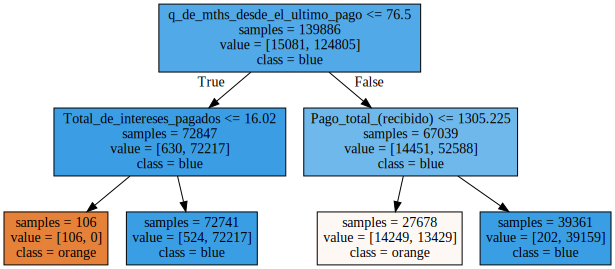

In [21]:
#Se grafica el Arbol de decision teniendo en cuenta las variables numéricas
from sklearn.tree import export_graphviz
import graphviz
print(tree.classes_)
export_graphviz(tree, out_file="tree.dot",feature_names=X_train_num.columns, class_names=["orange", "blue"], impurity=False, filled=True)
with open("tree.dot") as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)
